In [73]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

In [2]:
from src.text_rank import TextRank

In [3]:
import networkx as nx
import plotly.offline as py
import plotly.graph_objects as go

In [4]:
from src.GWY_news_utils import (aggregate_content,calculate_attitude_score,load_dictionary)




In [4]:
def get_keywords(sample_text_df,keyword_extractor,number = 10):
    
    all_keyword_list = []
    
    for text in sample_text_df:
        
        keyword_list = keyword_extractor.text_rank(text,number)
        keyword_list = [tup[0] for tup in keyword_list]
        
        all_keyword_list.append(keyword_list)
    
    return all_keyword_list




def create_text_graph(text,tr_keyword,threshold=0.2,save=False,name="a"):
    
    word_pair = tr_keyword._cut(text)
    co_graph = tr_keyword.co_occurance_matrix(word_pair)
    df = tr_keyword.co_occur_graph_to_matrix(co_graph,normalization=True)
    
    word_list = list(df.columns)
    
    name_dict = {}
    
    for i in range(len(word_list)):
        
        name_dict[i] = word_list[i]
        
    nx_graph = nx.from_numpy_array(df.values)
    nx_graph = nx.relabel_nodes(nx_graph,name_dict)  
    
    for edge in nx_graph.edges():
        
        if nx_graph.edges()[edge]['weight'] < threshold:
            
            nx_graph.edges()[edge]['weight'] = 0
        
    pos_ = nx.spring_layout(nx_graph)
    
    
    def make_edge(x, y, text, width):
        
        return  go.Scatter(x         = x,
                           y         = y,
                           line      = dict(width = width,
                                            color = 'black'),
                           hoverinfo = 'text',
                           text      = ([text]),
                           mode      = 'lines')
    
    edge_trace = []
    
    for edge in nx_graph.edges():
        
        if nx_graph.edges()[edge]['weight'] > 0:
            
            char_1 = edge[0]
            char_2 = edge[1]
            
            x0, y0 = pos_[char_1]
            x1, y1 = pos_[char_2]
            
            text   = char_1 + '--' + char_2 + ': ' + str(nx_graph.edges()[edge]['weight'])
            
            trace  = make_edge([x0, x1, None], [y0, y1, None], text, 
                               width = 0.9*nx_graph.edges()[edge]['weight']**1.5)
            
            
            edge_trace.append(trace)
    
    node_trace = go.Scatter(x         = [],
                            y         = [],
                            text      = [],
                            textposition = "top center",
                            textfont_size = 10,
                            mode      = 'markers+text',
                            hoverinfo = 'none',
                            marker    = dict(color = [],
                                             size  = [],
                                             line  = None))
    

    for node in nx_graph.nodes():
        
        x, y = pos_[node]
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
        node_trace['marker']['color'] += tuple(['cornflowerblue'])
        node_trace['marker']['size'] += tuple([8*1])
        node_trace['text'] += tuple(['<b>' + node + '</b>'])
    
    
    layout = go.Layout(
        paper_bgcolor='rgba(0,0,0,0)', # transparent background
        plot_bgcolor='rgba(0,0,0,0)', # transparent 2nd background
        xaxis =  {'showgrid': False, 'zeroline': False}, # no gridlines
        yaxis = {'showgrid': False, 'zeroline': False}, # no gridlines
    )
    
        
    
    fig = go.Figure(layout = layout)
    
    for trace in edge_trace:
        fig.add_trace(trace)
    
    fig.add_trace(node_trace)
    fig.update_layout(showlegend = False)
    fig.update_xaxes(showticklabels = False)
    fig.update_yaxes(showticklabels = False)
    
    if save:
        
        fig.write_html("data/output/plot/"+name+".html")
    
    else:
        fig.show()

    
    
    
def aggregate_texts(text_df):
    
    total_string = ""
    
    for string in text_df:
        
        total_string += string
    
    return total_string

In [71]:
def calculate_correlation_df(agg_df):
    
    corr_df = agg_df.corr()
    corr_df = corr_df.round(3)
    
    rho = corr_df
    pval = agg_df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
    p = pval.applymap(lambda x: ''.join(['*' for t in [0.01] if x<=t]))
    corr_p_df = rho.astype(str) + p
    return corr_p_df

In [5]:
data_dir = "data/output/"

### Import index dataframe

In [6]:
daily_index_df = pd.read_csv(data_dir+"daily_score_df.csv")
daily_index_df.index = pd.to_datetime(daily_index_df.date)
daily_index_df = daily_index_df.iloc[:,1:]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x125753cd0>,
      dtype=object)

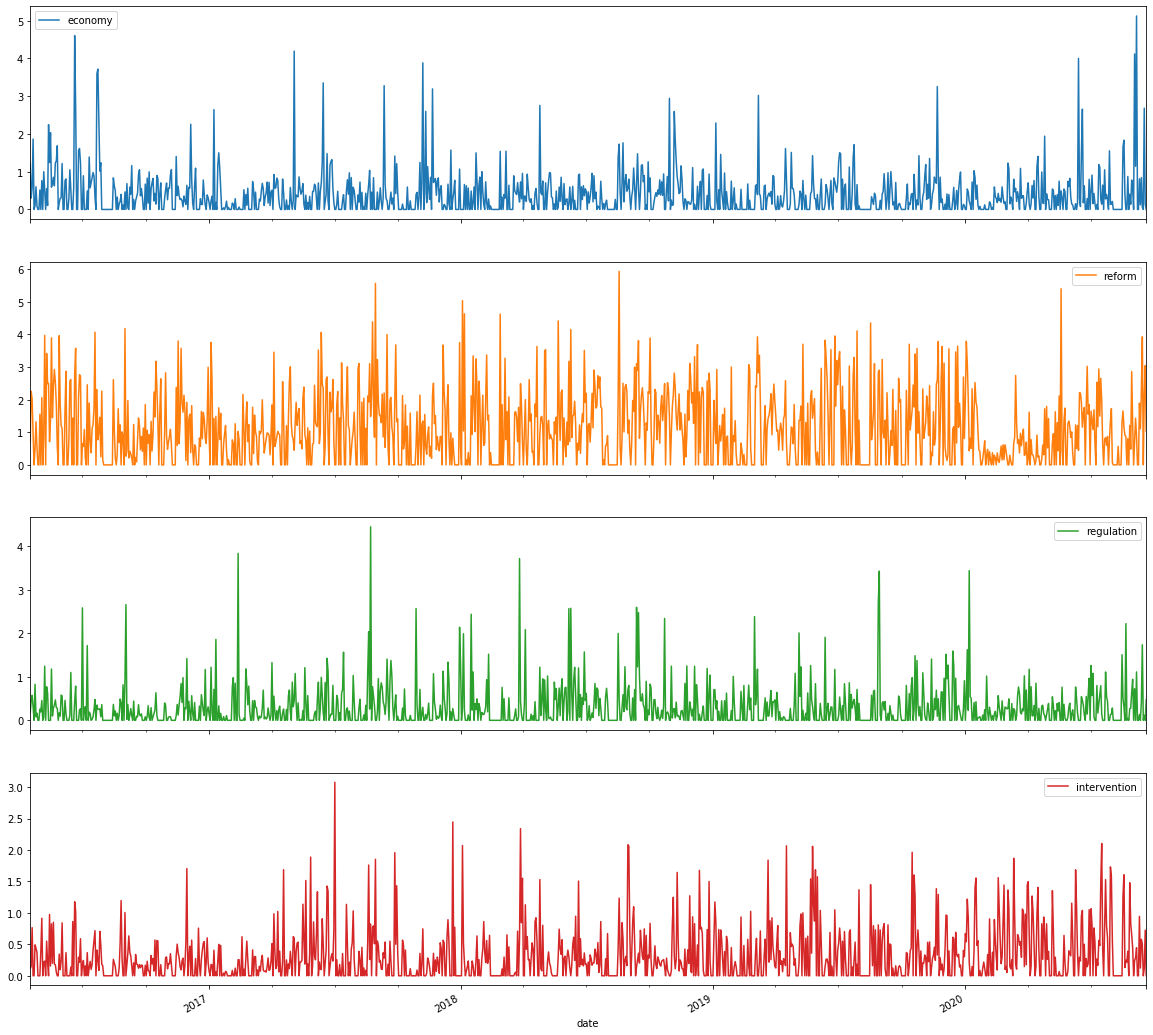

In [7]:
daily_index_df.plot(subplots=True,figsize=(20,20))

In [8]:
eco_quantile = pd.qcut(daily_index_df.economy,100,labels=False,duplicates="drop")
reform_quantile = pd.qcut(daily_index_df.reform,100,labels=False,duplicates="drop")
reg_quantile = pd.qcut(daily_index_df.regulation,100,labels=False,duplicates="drop")
inter_quantile = pd.qcut(daily_index_df.intervention,100,labels=False,duplicates="drop")

In [9]:
daily_index_qcut_df = pd.concat([eco_quantile,reform_quantile,reg_quantile,inter_quantile],axis=1)

daily_index_qcut_df.max()

special_eco_date = daily_index_qcut_df.index[daily_index_qcut_df.economy == 62]
special_reform_date = daily_index_qcut_df.index[daily_index_qcut_df.reform == 71]
special_regulation_date = daily_index_qcut_df.index[daily_index_qcut_df.regulation == 57]
special_intervention_date = daily_index_qcut_df.index[daily_index_qcut_df.intervention == 62]

In [10]:
daily_index_qcut_df.max()

economy         62
reform          71
regulation      57
intervention    62
dtype: int64

In [11]:
special_eco_date = daily_index_qcut_df.index[daily_index_qcut_df.economy == 62]
special_reform_date = daily_index_qcut_df.index[daily_index_qcut_df.reform == 71]
special_regulation_date = daily_index_qcut_df.index[daily_index_qcut_df.regulation == 57]
special_intervention_date = daily_index_qcut_df.index[daily_index_qcut_df.intervention == 62]

### Import content

In [12]:
content = pd.read_csv("data/daily_content_aggregate.csv")
content.index = pd.to_datetime(content.date)
content = content.iloc[:,1:].content

In [13]:
collection = []
error_list = []

for date in special_eco_date:
    
    try:
        if len(content.loc[str(date.date())]) > 0:
            
            collection.append(content.loc[str(date.date())])
        
        else:
            
            error_list.append(date)
    except:
        
        print(date)
        
        

In [14]:
special_eco_df = pd.Series(collection)
special_eco_df.index = special_eco_date

In [15]:
collection = []
error_list = []

for date in special_reform_date:
    
    try:
        if len(content.loc[str(date.date())]) > 0:
            
            collection.append(content.loc[str(date.date())])
        
        else:
            
            error_list.append(date)
    except:
        
        print(date)

In [16]:
special_reform_df = pd.Series(collection)
special_reform_df.index = special_reform_date


In [17]:
collection = []
error_list = []

for date in special_regulation_date:
    
    try:
        if len(content.loc[str(date.date())]) > 0:
            
            collection.append(content.loc[str(date.date())])
        
        else:
            
            error_list.append(date)
    except:
        
        print(date)

In [18]:
special_regulation_df = pd.Series(collection)
special_regulation_df.index = special_regulation_date

In [19]:
collection = []
error_list = []

for date in special_intervention_date:
    
    try:
        if len(content.loc[str(date.date())]) > 0:
            
            collection.append(content.loc[str(date.date())])
        
        else:
            
            error_list.append(date)
    except:
        
        print(date)

In [20]:
special_intervention_df = pd.Series(collection)
special_intervention_df.index = special_intervention_date

# Keyword Detection

In [28]:
with open("data/dictionary/baidu_stopwords.txt") as f:
    
    stopwords = f.readlines()


In [29]:
stopwords = [word.strip() for word in stopwords]
allowPOS = ["n"]
span = 3
tr_keyword = TextRank(allowPOS,stopwords,span)

In [30]:
word_list = get_keywords(special_eco_df,keyword_extractor=tr_keyword,number = 10)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/1y/w6y_szxn0m12nsrrdnzgp4540000gn/T/jieba.cache
Loading model cost 1.506 seconds.
Prefix dict has been built successfully.


In [31]:
word_list 

[['金融', '市场', '经济', '企业', '金融风险', '资本', '风险', '实体', '金融市场', '消费者'],
 ['经济', '国际', '政策', '世界', '全球', '金融', '体系', '份额', '市场', '金融机构'],
 ['经济', '政策', '世界', '开创性', '负责人', '非金融', '财政', '企业', '区域性', '金融机构'],
 ['金融', '经济', '实体', '贷款', '银行', '金融服务', '事关', '部署', '故事', '会议'],
 ['绿色', '金融', '地方', '机制', '政府', '环境', '项目', '积极探索', '负责人', '经济'],
 ['经济', '国际', '世界', '金融机构', '创业', '全球', '全球化', '共同体', '结构性', '经济体'],
 ['金融', '企业', '金融服务', '体系', '机制', '部门', '特色', '思想', '能力', '部署'],
 ['经济', '团体', '经济界', '基础', '顺应时代', '机遇', '民间', '会议', '地方', '大方向'],
 ['经济', '世界', '企业', '全球', '连续性', '气候变化', '国际', '环境', '营商', '理事会'],
 ['经济', '产业', '主席国', '数字', '领导人', '肺炎', '疫情', '东盟国家', '新冠', '人类'],
 ['经济', '企业', '金融', '实体', '核电', '会议', '控股公司', '金融机构', '主体', '规模'],
 ['经济', '金融', '实体', '控股公司', '企业', '个体', '力度', '金融机构', '规模', '总资产']]

### Top vs Bottom Percentile Keywords

#### Economy

In [32]:
special_eco_date = daily_index_qcut_df.index[daily_index_qcut_df.economy == 62]
bottom_eco_date = daily_index_qcut_df.index[daily_index_qcut_df.economy == 1]

In [33]:
collection = []
error_list = []

for date in special_eco_date:
    
    try:
        if len(content.loc[str(date.date())]) > 0:
            
            collection.append(content.loc[str(date.date())])
        
        else:
            
            error_list.append(date)
    except:
        
        print(date)

top_eco_df = pd.Series(collection)
top_eco_df.index = special_eco_date

In [34]:
collection = []
error_list = []

for date in bottom_eco_date:
    
    try:
        if len(content.loc[str(date.date())]) > 0:
            
            collection.append(content.loc[str(date.date())])
        
        else:
            
            error_list.append(date)
    except:
        
        print(date)

bottom_eco_df = pd.Series(collection)
bottom_eco_df.index = bottom_eco_date

In [35]:
stopwords = [word.strip() for word in stopwords]
allowPOS = ["n"]
span = 3
tr_keyword = TextRank(allowPOS,stopwords,span)

In [36]:
top_eco_word_list = get_keywords(top_eco_df,keyword_extractor=tr_keyword,number = 5)
bottom_eco_word_list = get_keywords(bottom_eco_df,keyword_extractor=tr_keyword,number = 5)

In [37]:
bottom_eco_word_list = get_keywords(bottom_eco_df,keyword_extractor=tr_keyword,number = 5)

In [38]:
bottom_eco_word_list

[['文化', '学校', '历史', '会议', '地区'],
 ['评价', '企业', '钢铁', '会议', '煤炭行业'],
 ['精神', '水电', '旧址', '利用', '总理'],
 ['医疗', '校园', '资源', '群众', '大病'],
 ['部署', '群众', '环境', '人民', '科研'],
 ['政务', '数据', '群众', '部门', '企业'],
 ['总理', '上学', '打工者', '回家', '特色'],
 ['群众', '政务', '办理', '政府', '社会'],
 ['企业', '商业', '政策', '业务', '失业'],
 ['国际', '机构', '文物保护', '用电', '电价'],
 ['小区', '总理', '群众', '民生', '高原病'],
 ['市场', '国际', '产品', '企业', '董事长']]

#### Reform

In [39]:
top_reform_date = daily_index_qcut_df.index[daily_index_qcut_df.reform == 71]
bottom_reform_date = daily_index_qcut_df.index[daily_index_qcut_df.reform == 1]

In [40]:
collection = []
error_list = []

for date in top_reform_date:
    
    try:
        if len(content.loc[str(date.date())]) > 0:
            
            collection.append(content.loc[str(date.date())])
        
        else:
            
            error_list.append(date)
    except:
        
        print(date)

top_reform_df = pd.Series(collection)
top_reform_df.index = top_reform_date

In [41]:
collection = []
error_list = []

for date in bottom_reform_date:
    
    try:
        if len(content.loc[str(date.date())]) > 0:
            
            collection.append(content.loc[str(date.date())])
        
        else:
            
            error_list.append(date)
    except:
        
        print(date)

bottom_reform_df = pd.Series(collection)
bottom_reform_df.index = bottom_reform_date

In [42]:
stopwords = [word.strip() for word in stopwords]
allowPOS = ["v"]
span = 3
tr_keyword = TextRank(allowPOS,stopwords,span)

In [43]:
top_reform_word_list = get_keywords(top_reform_df,keyword_extractor=tr_keyword,number = 5)
bottom_reform_word_list = get_keywords(bottom_reform_df,keyword_extractor=tr_keyword,number = 5)

In [44]:
bottom_reform_word_list

[['防总', '抓紧', '避险', '转移', '受灾'],
 ['希望', '返乡', '发现', '搬迁', '打工'],
 ['砥砺', '并进', '题为', '聚集', '毗邻'],
 ['青睐', '开工', '补齐', '备受', '具备'],
 ['就业', '创造', '促进', '增加', '安排'],
 ['保障', '做好', '组长', '提高', '组织'],
 ['抓紧', '支持', '加快', '做好', '就业'],
 ['统筹', '支持', '支付', '予以', '组长'],
 ['就业', '推迟', '返岗', '复工', '增加'],
 ['就业', '加快', '推进', '防范', '协助'],
 ['复工', '抓紧', '隔离', '转运', '防范'],
 ['扶贫', '低保', '延长', '纳入', '帮扶']]

#### Regulation

In [45]:
top_regulation_date = daily_index_qcut_df.index[daily_index_qcut_df.regulation == 57]
bottom_regulation_date = daily_index_qcut_df.index[daily_index_qcut_df.regulation == 1]

In [46]:
collection = []
error_list = []

for date in top_regulation_date:
    
    try:
        if len(content.loc[str(date.date())]) > 0:
            
            collection.append(content.loc[str(date.date())])
        
        else:
            
            error_list.append(date)
    except:
        
        print(date)

top_regulation_df = pd.Series(collection)
top_regulation_df.index = top_regulation_date

In [47]:
collection = []
error_list = []

for date in bottom_regulation_date:
    
    try:
        if len(content.loc[str(date.date())]) > 0:
            
            collection.append(content.loc[str(date.date())])
        
        else:
            
            error_list.append(date)
    except:
        
        print(date)

bottom_regulation_df = pd.Series(collection)
bottom_regulation_df.index = bottom_regulation_date

In [48]:
stopwords = [word.strip() for word in stopwords]
allowPOS = ["v"]
span = 3
tr_keyword = TextRank(allowPOS,stopwords,span)

In [49]:
top_regulation_word_list = get_keywords(top_regulation_df,keyword_extractor=tr_keyword,number = 5)
bottom_regulation_word_list = get_keywords(bottom_regulation_df,keyword_extractor=tr_keyword,number = 5)

#### Intervention

In [50]:
top_intervention_date = daily_index_qcut_df.index[daily_index_qcut_df.intervention == 62]
bottom_intervention_date = daily_index_qcut_df.index[daily_index_qcut_df.intervention == 1]

In [51]:
collection = []
error_list = []

for date in top_intervention_date:
    
    try:
        if len(content.loc[str(date.date())]) > 0:
            
            collection.append(content.loc[str(date.date())])
        
        else:
            
            error_list.append(date)
    except:
        
        print(date)

top_intervention_df = pd.Series(collection)
top_intervention_df.index = top_intervention_date

In [52]:
collection = []
error_list = []

for date in bottom_intervention_date:
    
    try:
        if len(content.loc[str(date.date())]) > 0:
            
            collection.append(content.loc[str(date.date())])
        
        else:
            
            error_list.append(date)
    except:
        
        print(date)

bottom_intervention_df = pd.Series(collection)
bottom_intervention_df.index = bottom_intervention_date

In [53]:
stopwords = [word.strip() for word in stopwords]
allowPOS = ["v"]
span = 3
tr_keyword = TextRank(allowPOS,stopwords,span)

In [54]:
top_intervention_word_list = get_keywords(top_intervention_df,keyword_extractor=tr_keyword,number = 5)
bottom_intervention_word_list = get_keywords(bottom_intervention_df,keyword_extractor=tr_keyword,number = 5)

In [55]:
top_intervention_word_list

[['致以', '支持', '维护', '受伤', '慰问'],
 ['减税', '降费', '承诺', '作出', '领取'],
 ['支持', '推进', '转岗', '提高', '促进'],
 ['补助', '推动', '创新', '保障', '增收'],
 ['创新', '加大', '支持', '提升', '力推'],
 ['到位', '累计', '支持', '缓解', '退还'],
 ['减税', '减轻', '鼓励', '拨付', '负担'],
 ['鼓励', '减税', '减轻', '创新', '给予'],
 ['促进', '答复', '提案', '推动', '期盼'],
 ['降费', '减税', '负担', '退税', '办好'],
 ['减税', '支持', '通知', '便利化', '就业'],
 ['就业', '示范', '打破', '创新', '引导']]

In [56]:
bottom_intervention_word_list

[['共享', '就业', '滥用', '建立', '增长'],
 ['执法', '预防', '发生', '倾斜', '推进'],
 ['转岗', '得知', '外出', '未能', '开放'],
 ['推动', '支持', '提高', '享受', '协定'],
 ['涉及', '过剩', '统计', '奉行', '提供'],
 ['就业', '抓紧', '推进', '转变', '推动'],
 ['推进', '发挥', '关切', '作用', '激发'],
 ['希望', '联合', '有利于', '开放', '做出'],
 ['创新', '就业', '询问', '考察', '打造'],
 ['会晤', '承建', '希望', '直航', '开放'],
 ['休息', '推进', '统筹', '输入', '抓好'],
 ['就业', '增长', '用于', '推动', '遭受']]

### Top vs Bottom Graph Representation

In [55]:
stopwords = [word.strip() for word in stopwords]
allowPOS = ["n","v"]
span = 3
tr_keyword = TextRank(allowPOS,stopwords,span)

#### Economy

In [57]:
top_eco_string = aggregate_texts(top_eco_df)
bottom_eco_string = aggregate_texts(bottom_eco_df)

In [58]:
create_text_graph(bottom_eco_string,tr_keyword,threshold=0.3,save=True,name="bottom_economy_index")

In [59]:
create_text_graph(top_eco_string,tr_keyword,threshold=0.3,save=True,name="top_economy_index")

#### Reform

In [60]:
top_reform_string = aggregate_texts(top_reform_df)
bottom_reform_string = aggregate_texts(bottom_reform_df)

In [309]:
create_text_graph(top_reform_string,tr_keyword,threshold=0.3,save=True,name="top_reform_index")
create_text_graph(bottom_reform_string,tr_keyword,threshold=0.3,save=True,name="bottom_reform_index")

#### Regulation

In [61]:
top_regulation_string = aggregate_texts(top_regulation_df)
bottom_regulation_string = aggregate_texts(bottom_regulation_df)

In [311]:
create_text_graph(top_regulation_string,tr_keyword,threshold=0.3,save=True,name="top_regulation_index")
create_text_graph(bottom_regulation_string,tr_keyword,threshold=0.3,save=True,name="bottom_regulation_index")

#### Intervention

In [59]:
top_intervention_string = aggregate_texts(top_intervention_df)
bottom_intervention_string = aggregate_texts(bottom_intervention_df)

In [313]:
create_text_graph(top_intervention_string,tr_keyword,threshold=0.3,save=True,name="top_intervention_index")
create_text_graph(bottom_intervention_string,tr_keyword,threshold=0.3,save=True,name="bottom_intervention_index")

### Top 10 Daily Text Read

In [64]:
data_directory = "result/"

In [66]:
top_intervention_df.to_excel(data_directory+"top_intervention_inspection.xls")

In [67]:
top_reform_df.to_excel(data_directory+"top_reform_inspection.xls")

In [65]:
top_regulation_df.to_excel(data_directory+"top_regulation_inspection.xls")

In [66]:
top_regulation_df

date
2016-07-01    新华社北京7月1日电 国务院总理李克强日前签署第670号国务院令，公布《国务院关于修改〈中华...
2016-09-02    “完善无线电管理，既要有效开发利用，更要依靠法律手段，加大对利用‘伪基站’等开展电信诈骗等违...
2017-02-13    “这次修改通过的《条例》有一个很大进步，就是把原来三个部门的职能合并到了一起。这对破解‘几龙...
2017-08-23    国务院总理李克强8月23日主持召开国务院常务会议，部署推进央企深化改革降低杠杆工作，促进企业...
2017-10-27    党中央、国务院高度重视严格控制党政机关办公楼等楼堂馆所建设，把严格控制楼堂馆所建设作为落实中...
2018-03-27    快递业是服务业的重要组成部分，连接供给侧和消费侧，是推动流通方式转型、促进消费升级的先导产业...
2018-06-06    国务院总理李克强6月6日主持召开国务院常务会议，部署在市场监管领域推进管理方式改革和创新，全...
2018-06-08    当天会议部署在市场监管领域推进管理方式改革和创新，全面推行“双随机、一公开”监管。会议确定了...
2018-09-12    国务院总理李克强9月12日下午在人民大会堂会见日本经济团体联合会会长中西宏明、日中经济协会会...
2019-08-28    国务院总理李克强8月28日主持召开国务院常务会议，部署深化放管结合加强事中事后监管，促进公平...
2019-08-29    当天会议部署深化放管结合加强事中事后监管，促进公平竞争提升市场效率。李克强表示，按照党中央、...
2020-01-07    党中央、国务院高度重视解决拖欠农民工工资问题。为了规范农民工工资支付行为，保障农民工按时足额...
dtype: object

In [67]:
weekly_index_df = pd.read_csv(data_dir+"weekly_score_df.csv")
weekly_index_df.index = pd.to_datetime(weekly_index_df.date)
weekly_index_df = weekly_index_df.iloc[:,1:]

In [75]:
eco_quantile = pd.qcut(weekly_index_df.economy,10,labels=False,duplicates="drop")
reform_quantile = pd.qcut(weekly_index_df.reform,10,labels=False,duplicates="drop")
reg_quantile = pd.qcut(weekly_index_df.regulation,10,labels=False,duplicates="drop")
inter_quantile = pd.qcut(weekly_index_df.intervention,10,labels=False,duplicates="drop")

In [76]:
weekly_index_qcut_df = pd.concat([eco_quantile,reform_quantile,reg_quantile,inter_quantile],axis=1)

weekly_index_qcut_df.max()


economy         9
reform          9
regulation      9
intervention    9
dtype: int64

In [77]:
special_eco_date = weekly_index_qcut_df.index[weekly_index_qcut_df.economy == 9]
special_reform_date = weekly_index_qcut_df.index[weekly_index_qcut_df.reform == 9]
special_regulation_date = weekly_index_qcut_df.index[weekly_index_qcut_df.regulation == 9]
special_intervention_date = weekly_index_qcut_df.index[weekly_index_qcut_df.intervention == 9]

In [78]:
special_regulation_date

DatetimeIndex(['2016-05-15', '2017-01-15', '2017-02-12', '2017-08-27',
               '2017-09-24', '2017-10-29', '2017-12-31', '2018-01-07',
               '2018-01-21', '2018-04-08', '2018-05-06', '2018-06-10',
               '2018-08-05', '2018-08-19', '2018-09-16', '2018-12-30',
               '2019-03-03', '2019-05-05', '2019-08-18', '2019-09-01',
               '2019-12-08', '2019-12-15', '2020-07-05', '2020-08-16'],
              dtype='datetime64[ns]', name='date', freq=None)

In [ ]:
top_regulation_date = weekly_index_qcut_df.index[weekly_index_qcut_df.regulation == ]

In [94]:
collection = []
error_list = []

for date in special_regulation_date:
    
    try:
        if len(weekly_series.loc[str(date.date())]) > 0:
            
            collection.append(weekly_series.loc[str(date.date())])
        
        else:
            
            error_list.append(date)
    except:
        
        print(date)

top_regulation_df = pd.Series(collection)
top_regulation_df.index = special_regulation_date

In [96]:
top_regulation_df.to_excel(data_directory+"top_regulation_inspection_weekly.xls")

### Sub-class Index

In [77]:
import matplotlib.pyplot as plt

In [5]:
data_directory = "data/output/sub_class/"

In [7]:
import os

In [9]:
index_list = os.listdir(data_directory)

In [11]:
index_list

['index_open_m.csv',
 'index_trade_m.csv',
 'index_small_company_intervention_m.csv',
 'index_simplify_m.csv',
 'index_private_w.csv',
 'index_entrepreneurial_d.csv',
 'index_entrepreneurial_w.csv',
 'index_private_d.csv',
 'index_small_company_intervention_d.csv',
 'index_simplify_d.csv',
 'index_entrepreneurial_m.csv',
 'index_private_m.csv',
 'index_simplify_w.csv',
 'index_small_company_intervention_w.csv',
 'index_trade_w.csv',
 'index_open_d.csv',
 'index_open_w.csv',
 'index_trade_d.csv']

#### Open Market 

In [23]:
open_daily = pd.read_csv(data_directory+"index_open_d.csv")
open_weekly = pd.read_csv(data_directory+"index_open_w.csv")
open_monthly = pd.read_csv(data_directory+"index_open_m.csv")

In [27]:
def fill(x):
    
    return "20"+x


open_monthly["date"] = open_monthly.date.apply(fill)

In [28]:
open_daily.index = pd.to_datetime(open_daily.date)
open_daily = open_daily.iloc[:,1:]

open_weekly.index = pd.to_datetime(open_weekly.date)
open_weekly = open_weekly.iloc[:,1:]

open_monthly.index = pd.to_datetime(open_monthly.date)
open_monthly = open_monthly.iloc[:,1:]


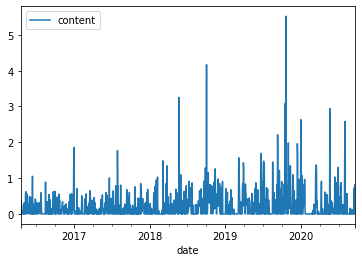

In [79]:
open_daily.plot()
plt.savefig("result/open_daily.png")

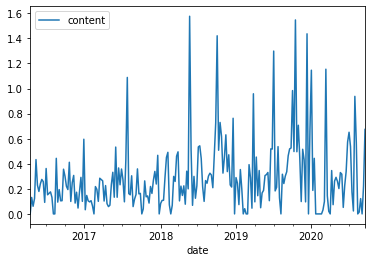

In [30]:
open_weekly.plot()
plt.savefig("result/open_daily.png")

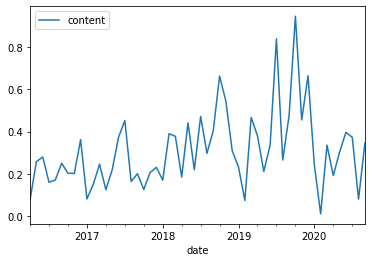

In [31]:
open_monthly.plot()

#### Trade

In [34]:
trade_daily = pd.read_csv(data_directory+"index_trade_d.csv")
trade_weekly = pd.read_csv(data_directory+"index_trade_w.csv")
trade_monthly = pd.read_csv(data_directory+"index_trade_m.csv")

In [36]:
trade_daily.index = pd.to_datetime(trade_daily.date)
trade_daily = trade_daily.iloc[:,1:]

trade_weekly.index = pd.to_datetime(trade_weekly.date)
trade_weekly = trade_weekly.iloc[:,1:]

trade_monthly.index = pd.to_datetime(trade_monthly.date)
trade_monthly = trade_monthly.iloc[:,1:]

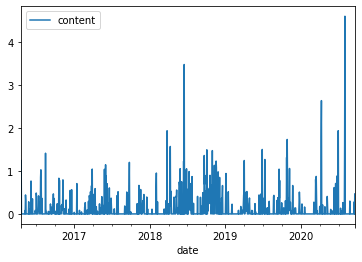

In [37]:
trade_daily.plot()

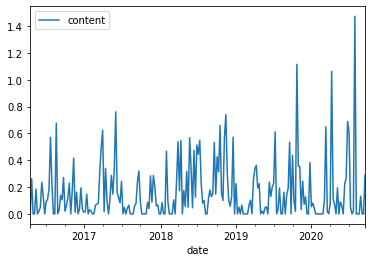

In [38]:
trade_weekly.plot()

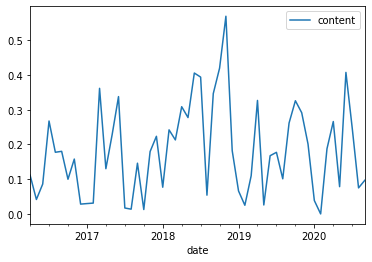

In [39]:
trade_monthly.plot()

#### Entrepreneurial

In [41]:
entre_daily = pd.read_csv(data_directory+"index_entrepreneurial_d.csv")
entre_weekly = pd.read_csv(data_directory+"index_entrepreneurial_w.csv")
entre_monthly = pd.read_csv(data_directory+"index_entrepreneurial_m.csv")

In [43]:
entre_daily.index = pd.to_datetime(entre_daily.date)
entre_daily = entre_daily.iloc[:,1:]

entre_weekly.index = pd.to_datetime(entre_weekly.date)
entre_weekly = entre_weekly.iloc[:,1:]

entre_monthly.index = pd.to_datetime(entre_monthly.date)
entre_monthly = entre_monthly.iloc[:,1:]

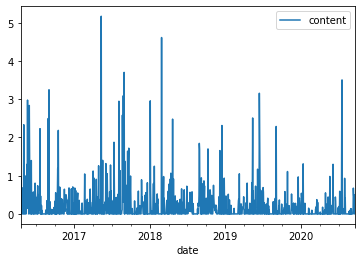

In [44]:
entre_daily.plot()

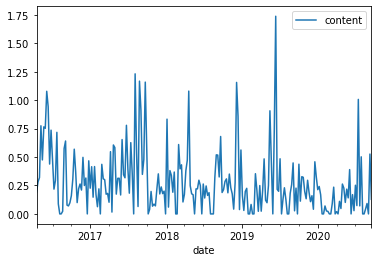

In [45]:
entre_weekly.plot()

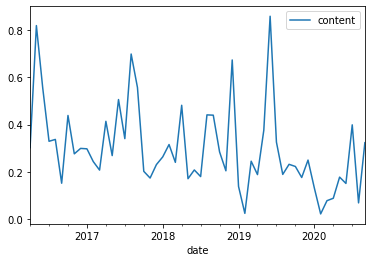

In [47]:
entre_monthly.plot()

In [48]:
index_list

['index_open_m.csv',
 'index_trade_m.csv',
 'index_small_company_intervention_m.csv',
 'index_simplify_m.csv',
 'index_private_w.csv',
 'index_entrepreneurial_d.csv',
 'index_entrepreneurial_w.csv',
 'index_private_d.csv',
 'index_small_company_intervention_d.csv',
 'index_simplify_d.csv',
 'index_entrepreneurial_m.csv',
 'index_private_m.csv',
 'index_simplify_w.csv',
 'index_small_company_intervention_w.csv',
 'index_trade_w.csv',
 'index_open_d.csv',
 'index_open_w.csv',
 'index_trade_d.csv']

#### Private

In [50]:
private_daily = pd.read_csv(data_directory+"index_private_d.csv")
private_weekly = pd.read_csv(data_directory+"index_private_w.csv")
private_monthly = pd.read_csv(data_directory+"index_private_m.csv")

In [51]:
private_daily.index = pd.to_datetime(private_daily.date)
private_daily = private_daily.iloc[:,1:]

private_weekly.index = pd.to_datetime(private_weekly.date)
private_weekly = private_weekly.iloc[:,1:]

private_monthly.index = pd.to_datetime(private_monthly.date)
private_monthly = private_monthly.iloc[:,1:]

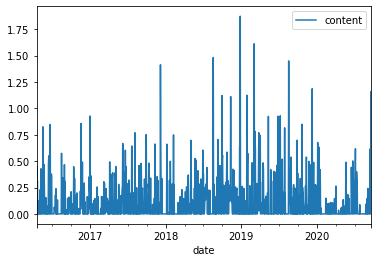

In [52]:
private_daily.plot()


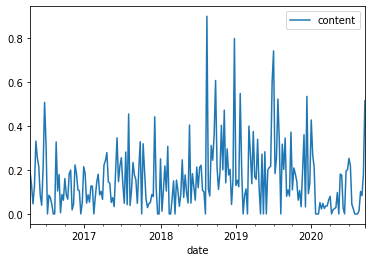

In [53]:
private_weekly.plot()

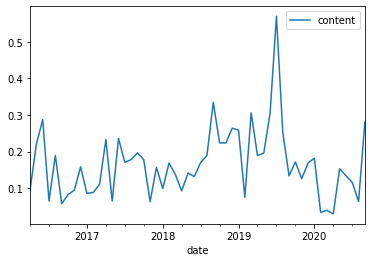

In [54]:
private_monthly.plot()

#### Small Company

In [55]:
small_daily = pd.read_csv(data_directory+"index_small_company_intervention_d.csv")
small_weekly = pd.read_csv(data_directory+"index_small_company_intervention_w.csv")
small_monthly = pd.read_csv(data_directory+"index_small_company_intervention_m.csv")

In [56]:
small_daily.index = pd.to_datetime(small_daily.date)
small_daily = small_daily.iloc[:,1:]

small_weekly.index = pd.to_datetime(small_weekly.date)
small_weekly = small_weekly.iloc[:,1:]

small_monthly.index = pd.to_datetime(small_monthly.date)
small_monthly = small_monthly.iloc[:,1:]

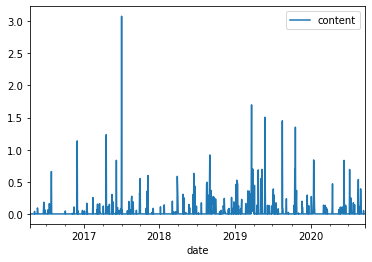

In [57]:
small_daily.plot()

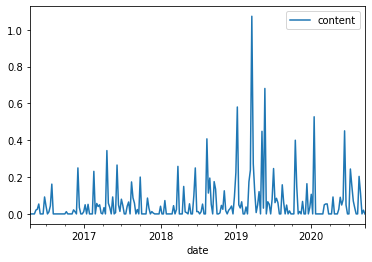

In [58]:
small_weekly.plot()

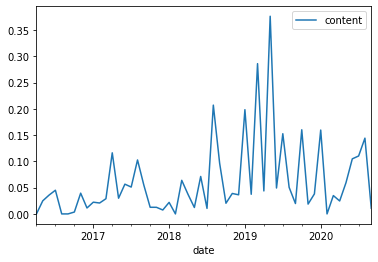

In [59]:
small_monthly.plot()

#### Simplification of policy

In [60]:
simplify_daily = pd.read_csv(data_directory+"index_simplify_d.csv")
simplify_weekly = pd.read_csv(data_directory+"index_simplify_w.csv")
simplify_monthly = pd.read_csv(data_directory+"index_simplify_m.csv")

In [61]:
simplify_daily.index = pd.to_datetime(simplify_daily.date)
simplify_daily = simplify_daily.iloc[:,1:]

simplify_weekly.index = pd.to_datetime(simplify_weekly.date)
simplify_weekly = simplify_weekly.iloc[:,1:]

simplify_monthly.index = pd.to_datetime(simplify_monthly.date)
simplify_monthly = simplify_monthly.iloc[:,1:]

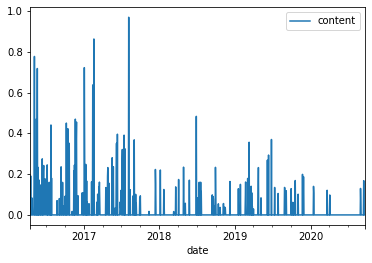

In [62]:
simplify_daily.plot()

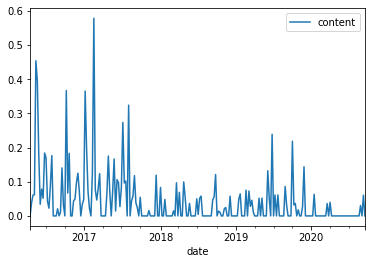

In [63]:
simplify_weekly.plot()

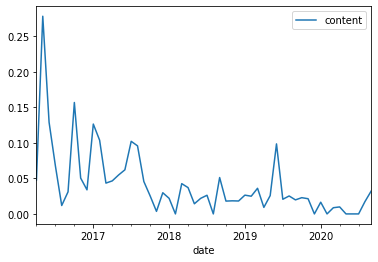

In [64]:
simplify_monthly.plot()

### Daily Result Study

In [66]:
daily_index_list = [open_daily,trade_daily,entre_daily,private_daily,small_daily,simplify_daily]
weekly_index_list = [open_weekly,trade_weekly,entre_weekly,private_weekly,small_weekly,simplify_weekly]
monthly_index_list = [open_monthly,trade_monthly,entre_monthly,private_monthly,small_monthly,simplify_monthly]

In [67]:
daily_index = pd.concat(daily_index_list,axis=1)
weekly_index = pd.concat(weekly_index_list,axis=1)
monthly_index = pd.concat(monthly_index_list,axis=1)

In [70]:
daily_index.columns = ["open","trade","innovation","private","small_company","simplify"]
weekly_index.columns = ["open","trade","innovation","private","small_company","simplify"]
monthly_index.columns = ["open","trade","innovation","private","small_company","simplify"]

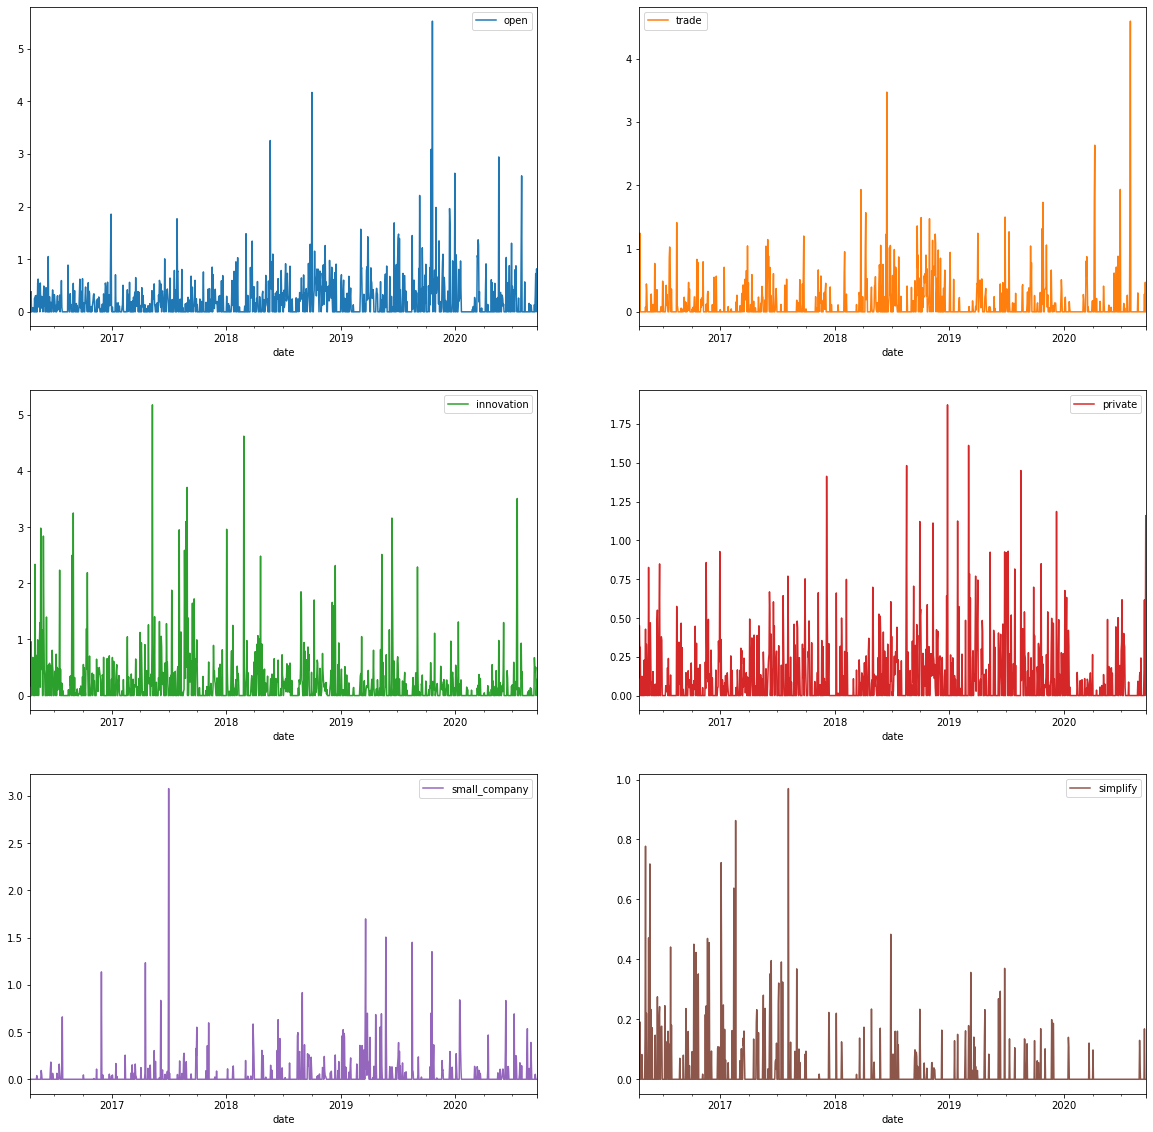

In [89]:
daily_index.plot(subplots=True,figsize=(20,20),layout=(3,2),sharex=False)
plt.savefig("result/daily_sub_class_index.png")

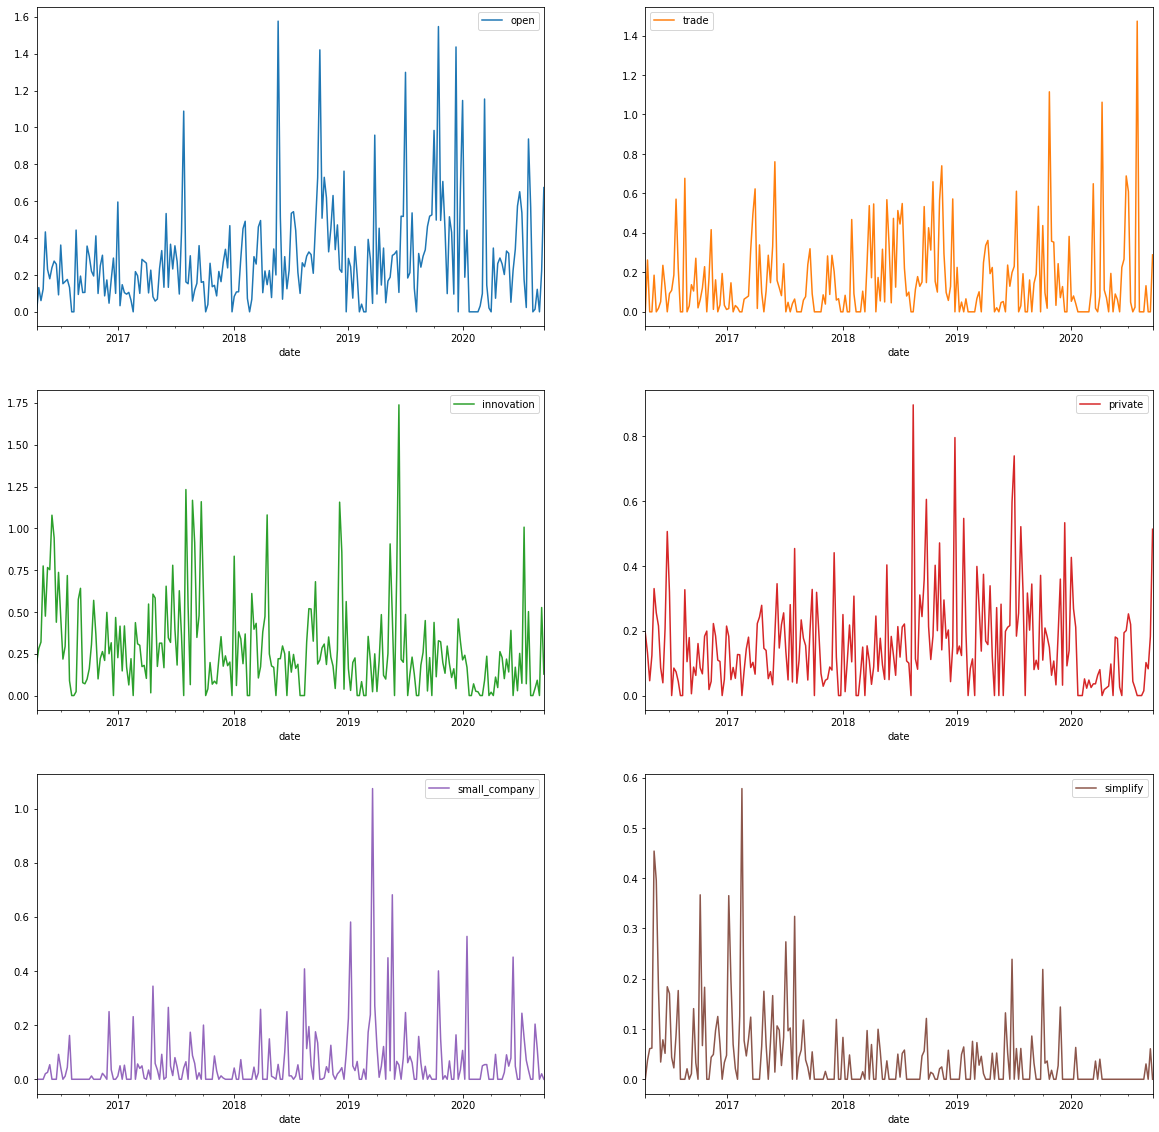

In [92]:
weekly_index.plot(subplots=True,figsize=(20,20),layout=(3,2),sharex=False)
plt.savefig("result/weekly_sub_class_index.png")

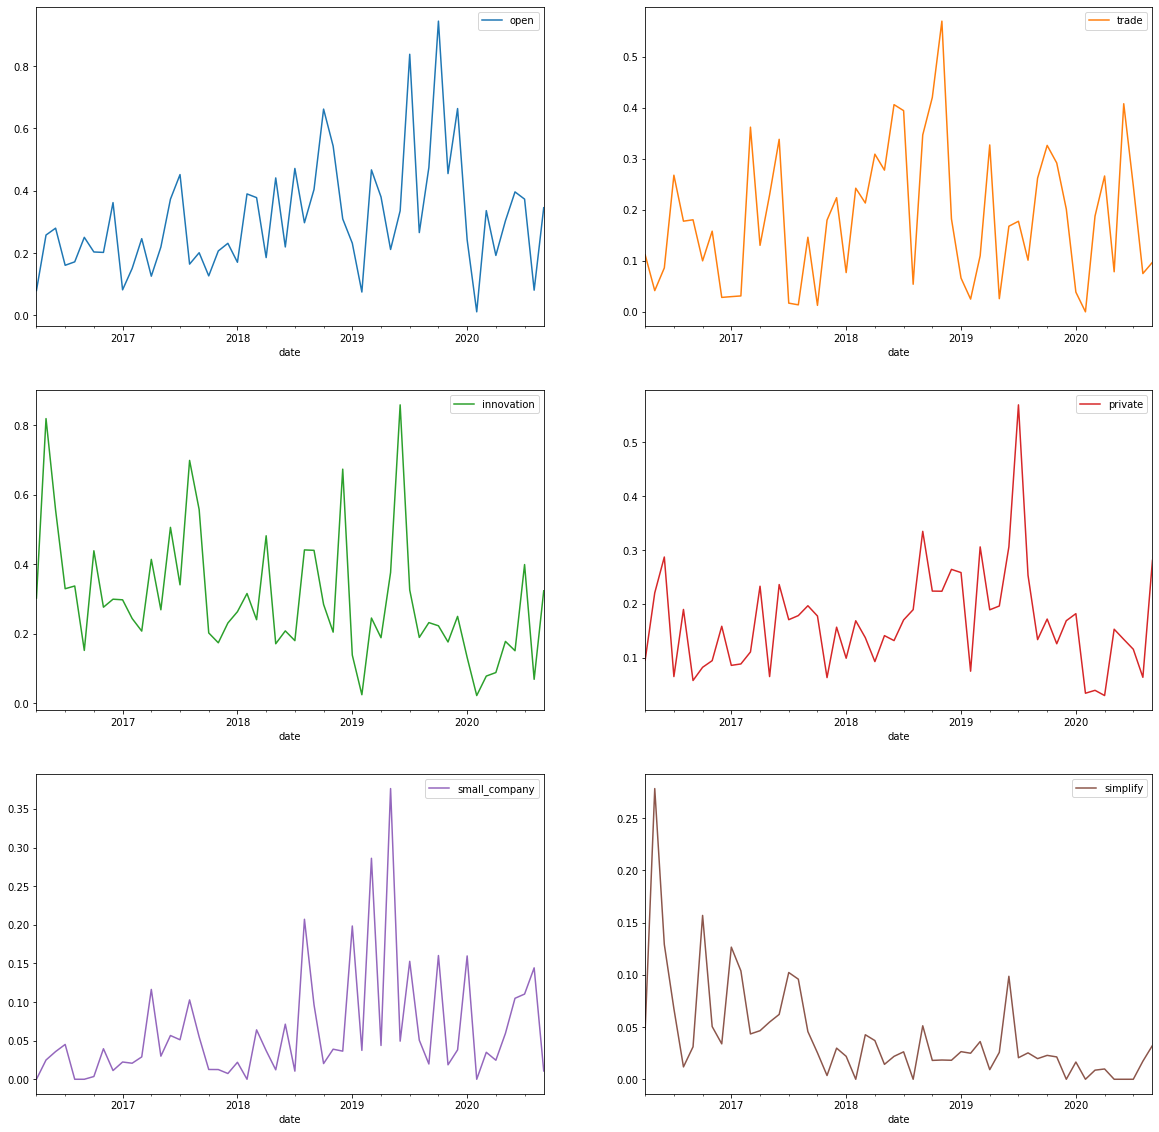

In [93]:
monthly_index.plot(subplots=True,figsize=(20,20),layout=(3,2),sharex=False)
plt.savefig("result/monthly_sub_class_index.png")

In [74]:
calculate_correlation_df(daily_index)

,open,trade,innovation,private,small_company,simplify
open,1.0*,0.375*,0.041,0.347*,0.062,0.003
trade,0.375*,1.0*,0.009,0.046,-0.006,-0.04
innovation,0.041,0.009,1.0*,0.136*,-0.0,0.14*
private,0.347*,0.046,0.136*,1.0*,0.196*,0.215*
small_company,0.062,-0.006,-0.0,0.196*,1.0*,0.067
simplify,0.003,-0.04,0.14*,0.215*,0.067,1.0*


In [75]:
calculate_correlation_df(weekly_index)

,open,trade,innovation,private,small_company,simplify
open,1.0*,0.44*,-0.043,0.353*,0.094,-0.066
trade,0.44*,1.0*,-0.015,0.006,-0.078,-0.108
innovation,-0.043,-0.015,1.0*,0.178*,-0.032,0.226*
private,0.353*,0.006,0.178*,1.0*,0.23*,0.136
small_company,0.094,-0.078,-0.032,0.23*,1.0*,0.042
simplify,-0.066,-0.108,0.226*,0.136,0.042,1.0*


In [76]:
calculate_correlation_df(monthly_index)

,open,trade,innovation,private,small_company,simplify
open,1.0*,0.486*,0.003,0.508*,0.163,-0.191
trade,0.486*,1.0*,-0.121,0.035,-0.176,-0.301
innovation,0.003,-0.121,1.0*,0.422*,0.041,0.606*
private,0.508*,0.035,0.422*,1.0*,0.358*,0.079
small_company,0.163,-0.176,0.041,0.358*,1.0*,-0.142
simplify,-0.191,-0.301,0.606*,0.079,-0.142,1.0*
